In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import feature_extraction
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud ,STOPWORDS
from nltk.stem.snowball import SnowballStemmer
import re
import os
import codecs
import mpld3

from bokeh.plotting import figure
from bokeh.io import output_notebook, show

from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure
from bokeh.sampledata.autompg import autompg_clean as df
from bokeh.transform import factor_cmap
from bokeh.models import FactorRange

output_notebook()

Loading BokehJS ...

In [2]:
## Load files
rating = pd.read_csv('jester_ratings.dat',sep='\t',header=None)
rating = rating[[0,2,4]]
rating.columns = ['id', 'Num','rating']
print(rating.shape)

with open('jester_items.dat') as f:
    n=0
    final=[]
    for line in f:
        if n ==0:
            l = line[:-1]
        else:
            l = l +  line[:-1]
        n+=1
        if line=='\n':
            final.append(l)
            n=0

(1761439, 3)


In [3]:
temp = pd.DataFrame({'contents': final,
                   'Num' : range(1,len(final)+1)})

data = pd.DataFrame({'contents': final,
                   'Num' : range(1,len(final)+1)})
data.contents = data.contents.apply(lambda x: x.replace('<p>',''))
data.contents = data.contents.apply(lambda x: x.replace('</p>',''))
data.contents = data.contents.apply(lambda x: x.replace('<br />',''))
data.contents = data.contents.apply(lambda x: x.replace('&quot;',''))
data.contents = data.contents.apply(lambda x: x.replace('&#039;','\''))
data = data.drop(132)
data = data.reset_index(drop=True)

## (1) The most frequent words

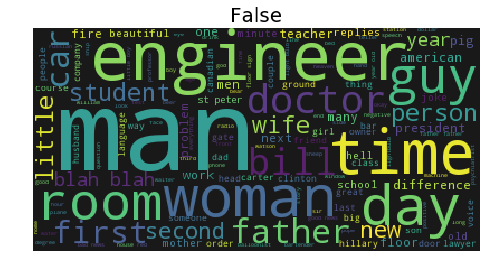

In [4]:
stopword=set(STOPWORDS)

def word_cloud(df, column,  label=False, bg='black',cmap='viridis'):
    df[column] = df[column].apply(lambda x:x.lower())
    df_word = df[column].apply(lambda x: word_tokenize(x)).values 
   
    t = np.asarray([j for i in range(len(df_word)) for j in df_word[i]])
    tagged = nltk.pos_tag(t)
    kk =(np.array([x[1] for x in tagged]) =='NN') | (np.array([x[1] for x in tagged]) =='JJ') | (np.array([x[1] for x in tagged]) =='NNP') | (np.array([x[1] for x in tagged]) =='NNS') | (np.array([x[1] for x in tagged]) =='NNPS')
    total = t[kk]
    
    wc= WordCloud(collocations=True,background_color=bg,max_words=2000,stopwords=stopword)
    wc.generate(" ".join(total))

    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(label, fontsize=20) #'
    plt.imshow(wc.recolor(colormap= cmap , random_state=17), alpha=0.9)
    plt.show()
    
    return(wc)

total=word_cloud(data,'contents')

## (2) Tf-idf and document similarity

In [5]:
stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

## TFIDF
tfidf_vectorizer = TfidfVectorizer(max_features=200000, stop_words='english',
                              use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(data.contents) #fit the vectorizer to synopses
print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()
cosine_sim = cosine_similarity(tfidf_matrix)
dist = 1 - cosine_sim

(149, 10453)


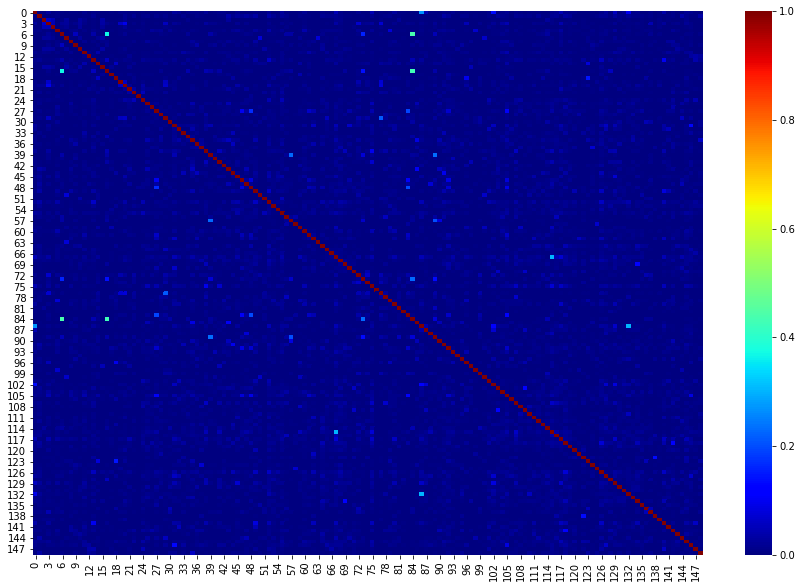

In [6]:
## glance at checking how many jokkings have similar each other
plt.figure(figsize=(15,10))
sns.heatmap(cosine_sim,cmap='jet')

## (3) Visualizing document clusters¶

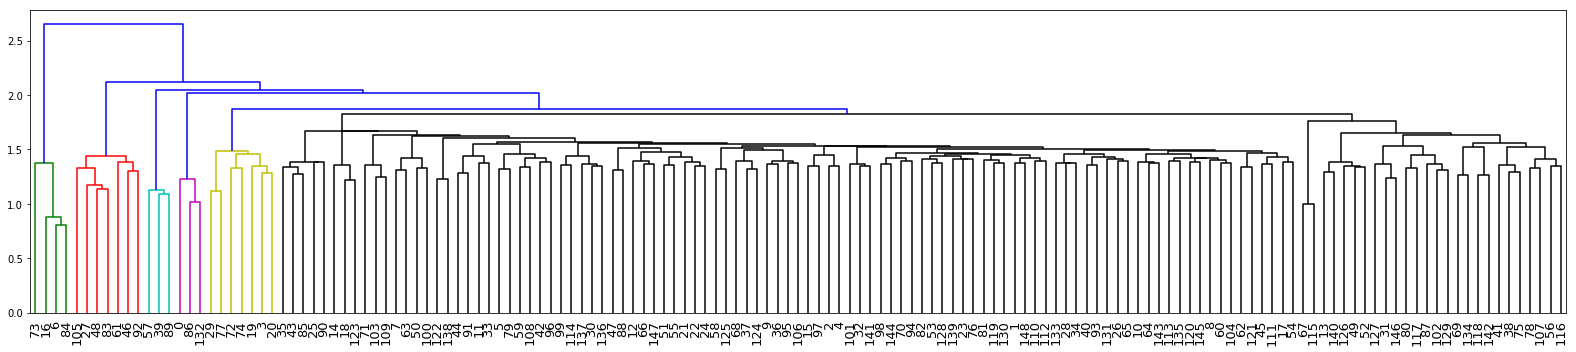

In [7]:
linkage_matrix = ward(dist)
fig, ax = plt.subplots(figsize=(22, 5)) 
ax = dendrogram(linkage_matrix, orientation="top", labels=data.index.values, leaf_font_size=13);

plt.tick_params(axis='y', which='both')
plt.tight_layout() 

plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

## (4) Best Joke vs. Worst Joke

In [12]:
new_rating = rating.merge(data, left_on='Num', right_on='Num', how='left')
df = new_rating.groupby('Num').median()['rating'].reset_index()
new = df.merge(temp, left_on='Num', right_on='Num', how='left')
new = new.sort_values('rating')
new = new.reset_index()

In [22]:
print('====================')
print('The best joke is : ')
print(new.iloc[-1].contents)
print('====================')
print('The worst joke is : ')
print(new.iloc[0].contents)

The best joke is : 
89:<p>A radio conversation between a US naval ship and Canadian authorities...<br /><br />Americans: Please divert your course 15 degrees to the North to avoid a collision.<br /><br />Canadians: Recommend you divert YOUR course 15 degrees to the South to avoid a collision.<br /><br />Americans: This is the captain of a US Navy ship. I say again, divert YOUR course.<br /><br />Canadians: No. I say again, you divert YOUR course.<br /><br />Americans: This is the aircraft carrier USS Lincoln, the second largest ship in the United States&#039; Atlantic Fleet. We are accompanied by three destroyers, three cruisers and numerous support vessels. I demand that you change your course 15 degrees North, that&#039;s ONE FIVE DEGREES NORTH, or counter-measures will be undertaken to ensure the safety of this ship.<br /><br />Canadians: This is a lighthouse. Your call.</p>
The worst joke is : 
141:<p>Jack Bauer can get McDonald&#039;s breakfast after 10:30.</p>


In [23]:
source = ColumnDataSource(new)
p = figure(plot_width=800, plot_height=1000, 
           title="Median Rating (Sorted by rating)", 
           toolbar_location=None, 
           tools="")

p.xgrid.grid_line_color = None
p.xaxis.axis_label = "Rating"
p.xaxis.major_label_orientation = 1.2

p.hbar(y='index', right='rating', height=1.1, source=source, fill_color='#2b83ba',
       line_color="white",hover_fill_color='#ffffbf')

#p.add_tools(HoverTool(tooltips=[("Contents", "@contents"),("Rating","@rating")]))
p.add_tools(HoverTool(tooltips = """
    Rating: @rating <br>
    <div>
      @contents
    </div>
"""))
show(p)